 # Models and Ensembling Methods

 ## Import dependencies

In [1]:
import numpy
from gensim.models import word2vec
from gensim.models import KeyedVectors
import pandas
from nltk import WordPunctTokenizer
from sklearn.preprocessing import label_binarize
import sqlite3
from sklearn.multiclass import OneVsRestClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve # The average precision score in multi-label settings
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm # Support Vector Machine
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import StackingClassifier


unable to import 'smart_open.gcs', disabling that module


 ## Read in the data

 ### Load raw train and test data

 #### Load in the data from the database

In [2]:
dbconn = sqlite3.connect('./data/cleanedtraintest_v2.db')
train_data_df = pandas.read_sql_query('SELECT category, content_cleaned FROM train_data', dbconn)
test_data_df = pandas.read_sql_query('SELECT category, content_cleaned FROM test_data', dbconn)
dbconn.commit()
dbconn.close()


 #### Check the if the data was loaded correctly

In [3]:
train_data_df


,category,content_cleaned
0,3,wall street seeing green
1,3,private investment firm carlyle group reputati...
2,3,soaring crude prices plus economy outlook earn...
3,3,authorities halted oil main pipeline southern ...
4,3,tearaway world oil prices toppling records str...
...,...,...
119995,1,pakistani president pervez musharraf said stay...
119996,2,red sox general manager theo epstein acknowled...
119997,2,miami dolphins put courtship lsu coach nick sa...
119998,2,pittsburgh ny giants time line steelers record...


In [4]:
test_data_df


,category,content_cleaned
0,3,unions representing workers turner newall say ...
1,4,toronto canada rocketeers competing million an...
2,4,company founded chemistry researcher universit...
3,4,barely dawn mike fitzpatrick starts shift blur...
4,4,southern california agency went emissions bovi...
...,...,...
7595,1,ukrainian presidential candidate viktor yushch...
7596,2,supply attractive pitching options dwindling d...
7597,2,like roger clemens almost exactly eight years ...
7598,3,singapore doctors united states warned painkil...


 #### Train & Test data where x is the predictor features, y is the predicted feature

In [5]:
N_CLASSES = 4

x_train = train_data_df.content_cleaned
y_train = label_binarize(train_data_df.category, classes=[1, 2, 3, 4])

x_test = test_data_df.content_cleaned
y_test = label_binarize(test_data_df.category, classes=[1, 2, 3, 4])


 ### Load word2vec data

 #### Load word2vec feature arrays from .npz files
 load dict of arrays

In [6]:
w2v_train_features_array_dict = numpy.load(
    './data/word2vec-train-features-120000-min5dim300.npz')
w2v_test_features_array_dict = numpy.load(
    './data/word2vec-test-features-120000-min5dim300.npz')
# extract the first array from train
data = w2v_train_features_array_dict['arr_0']
# print the array
print(data)
# extract the first array from test
data = w2v_test_features_array_dict['arr_0']
# print the array
print(data)


[[-0.43092448  0.50092196  0.08331972 ...  1.3914201   1.2953259
  -1.8574607 ]
 [-0.10783155 -0.35169265  0.90062636 ... -0.38979718  0.13664657
   0.5066641 ]
 [-1.0086536  -0.29255652 -0.7550053  ... -0.18521406  0.7896786
  -0.23576818]
 ...
 [-0.02566049  0.23409443 -0.8595321  ... -0.05427613 -0.89297265
  -0.09055152]
 [-0.6081659   0.42683512 -0.9105423  ... -0.06156884 -0.40654626
   0.07195716]
 [-1.0819023  -0.04211196 -0.16453283 ... -0.40625843 -0.13644677
  -0.0066904 ]]
[[-0.02657197 -1.0014614  -0.035705   ...  0.48677683  0.3947945
  -0.9894788 ]
 [-0.54866743 -1.3801866   0.66031504 ... -0.4012159   0.6803215
   0.92033225]
 [ 0.11171789  0.3781767  -0.26057357 ... -0.5006595   0.13674003
   0.10530389]
 ...
 [-0.46190766  0.7501185  -0.20256642 ... -0.32613838  0.09363924
   0.46578252]
 [-0.023529   -0.33200815 -0.63418424 ... -0.46149412  0.39634904
  -0.46027517]
 [-0.25388533 -0.6177681   0.9628809  ... -0.66557425 -0.1068292
  -0.64577085]]


 #### Load word2vec model trained key vectors

In [7]:
w2v_model_train = KeyedVectors.load(
    './data/custom-trained-word2vec-120000-min5dim300.kv')


 #### Get the word2vec data back into usable form

In [8]:
wpt = WordPunctTokenizer()
tokenized_corpus_train = [wpt.tokenize(document) for document in x_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in x_test]

del(x_train)
del(x_test)


In [9]:
def average_word_vectors(words, model, vocabulary, num_features):

 feature_vector = numpy.zeros((num_features,), dtype="float32")
 nwords = 0.

 for word in words:
    if word in vocabulary:
      nwords = nwords + 1.
      feature_vector = numpy.add(feature_vector, model[word])

 if nwords:
    feature_vector = numpy.divide(feature_vector, nwords)

 return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
 vocabulary = set(model.wv.index2word)
 features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
            for tokenized_sentence in corpus]
 return numpy.array(features)


 #### Obtain document level embeddings

In [10]:
FEATURE_SIZE = 300

w2v_feature_array_train = averaged_word_vectorizer(corpus=tokenized_corpus_train,
    model=w2v_model_train, num_features=FEATURE_SIZE)
w2v_feature_array_test = averaged_word_vectorizer(corpus=tokenized_corpus_test,
    model=w2v_model_train, num_features=FEATURE_SIZE)

x_train_w2v = pandas.DataFrame(w2v_feature_array_train)
x_test_w2v = pandas.DataFrame(w2v_feature_array_test)


 ## Build Models

 ### SVM Model Building Function

In [11]:
def run_svm(x_train, y_train):
    classifier = OneVsRestClassifier(svm.LinearSVC(random_state=1))
    classifier.fit(x_train, y_train)
    return classifier


 ### Logistic Regression Model Building Function

In [12]:
def run_logreg(x_train, y_train):
    classifier = OneVsRestClassifier(LogisticRegression(random_state=1))
    classifier.fit(x_train, y_train)
    return classifier


 ### Naive Bayes Function

In [13]:
def run_nb(x_train, y_train):
    classifier = OneVsRestClassifier(GaussianNB())
    classifier.fit(x_train, y_train)
    return classifier


 ### Decision Trees Function

In [14]:
def run_dectree(x_train, y_train):
    classifier = OneVsRestClassifier(tree.DecisionTreeClassifier())
    classifier.fit(x_train, y_train)
    return classifier 


 ### Functions to calculate scores and to plot them
 Calculate, then plot the Precision, Recall, Average Precision, F1

In [15]:
def prf1_calc(classifier, algo_name, n_classes, x_test, y_test):
    # Get the decision function from the classifier
    if algo_name == 'SVM':
        y_score = classifier.decision_function(x_test)
    else:
        y_score = classifier.predict_proba(x_test)
    y_pred = classifier.predict(x_test)

    # The average precision score in multi-label settings
    # For each class
    precision = dict()
    recall = dict()
    average_f1 = dict()
    average_precision = dict()
    mcc = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        average_f1[i] = f1_score(y_test[:, i], y_pred[:, i])
        mcc[i] = matthews_corrcoef(y_test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,
                                                        average="micro")
    average_f1['micro'] = f1_score(y_test, y_pred, average='micro')
    mcc['micro'] = sum(mcc.values())/4

    # Plot the data
    prf1_plot(precision, recall, average_precision, algo_name, n_classes)

    # Return all metrics
    results = pandas.DataFrame()

    for k in average_precision.keys():
        results.at[algo_name, f'P-R {k}'] = numpy.round(average_precision[k], 3)
        results.at[algo_name, f'F1 {k}'] = numpy.round(average_f1[k], 3)
        results.at[algo_name, f'MCC {k}'] = numpy.round(mcc[k], 3)

    return results

# Function to Plot Precision, Recall, F1
def prf1_plot(precision, recall, average_precision, algo_name, n_classes):
    print(algo_name)
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))

    # Plot the micro-averaged Precision-Recall curve
    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))
    
    # Plot Precision-Recall curve for each class and iso-f1 curves
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(7, 8))
    f_scores = numpy.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = numpy.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(lines, labels, loc=(0, -.5), prop=dict(size=14))

    plt.show()


 ## Run the Models

In [16]:
# Run SVM Model
svm_model = run_svm(x_train_w2v, y_train)


In [17]:
# Run Logistic Regression Model
logreg_model = run_logreg(x_train_w2v, y_train)


In [18]:
# Run Naive Bayes Classifier
nb_model = run_nb(x_train_w2v, y_train)


In [19]:
# Run Decision Trees Classifier
dectree_model = run_dectree(x_train_w2v, y_train)


 ## Get the scores

In [20]:
# Initialize the dataframe to keep track of the scores
scores = pandas.DataFrame()


SVM
Average precision score, micro-averaged over all classes: 0.92


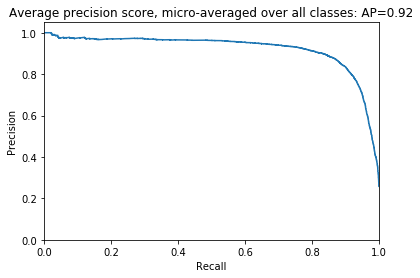

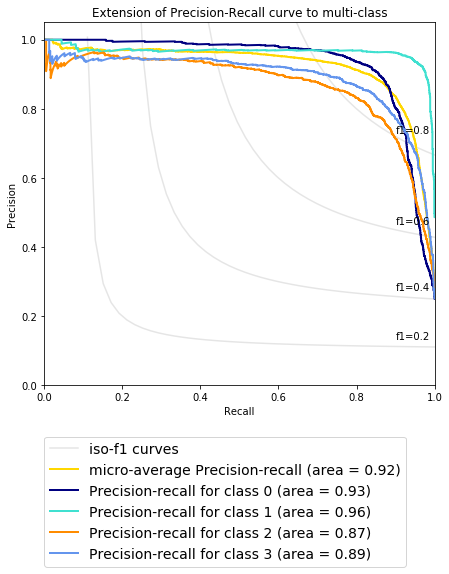

In [21]:
# Precision, Recall, Avg. Precision for SVM
scores = scores.append(prf1_calc(svm_model, 'SVM', N_CLASSES, x_test_w2v, y_test))


LOGREG
Average precision score, micro-averaged over all classes: 0.92


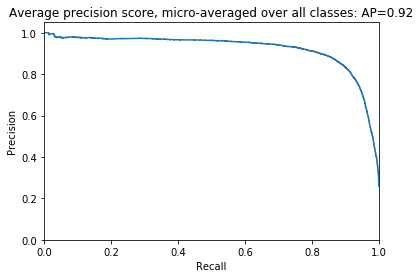

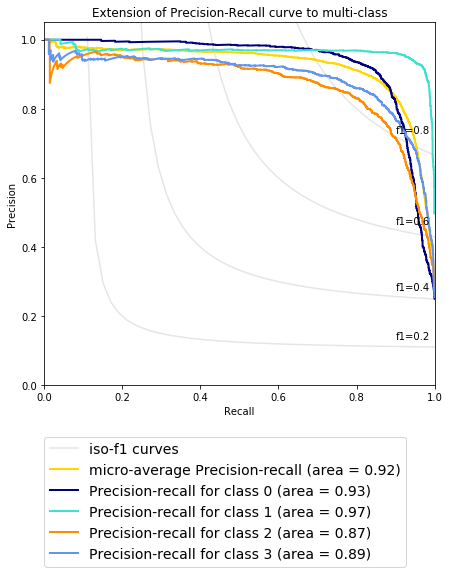

In [22]:
# Precision, Recall, Avg. Precision for LOG REG
scores = scores.append(prf1_calc(logreg_model, 'LOGREG', N_CLASSES, x_test_w2v, y_test))


NB
Average precision score, micro-averaged over all classes: 0.86


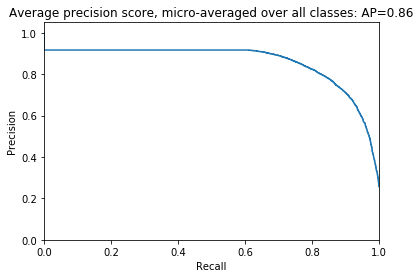

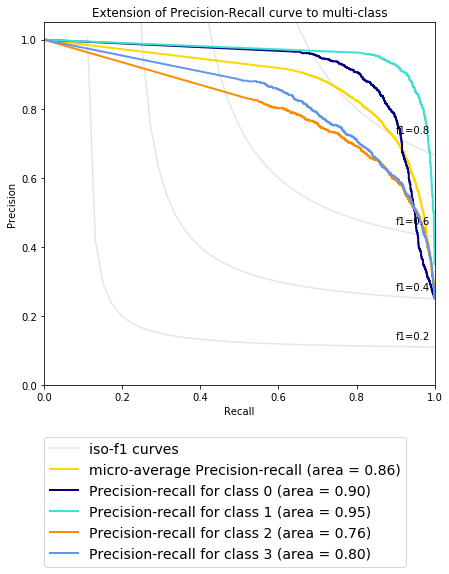

In [23]:
# Precision, Recall, Avg. Precision for Naive Bayes
scores = scores.append(prf1_calc(nb_model, 'NB', N_CLASSES, x_test_w2v, y_test))


DT
Average precision score, micro-averaged over all classes: 0.63


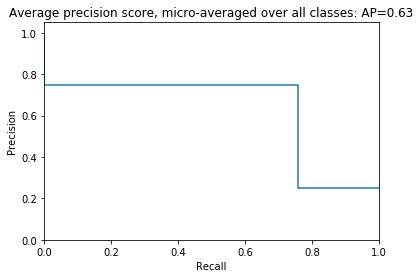

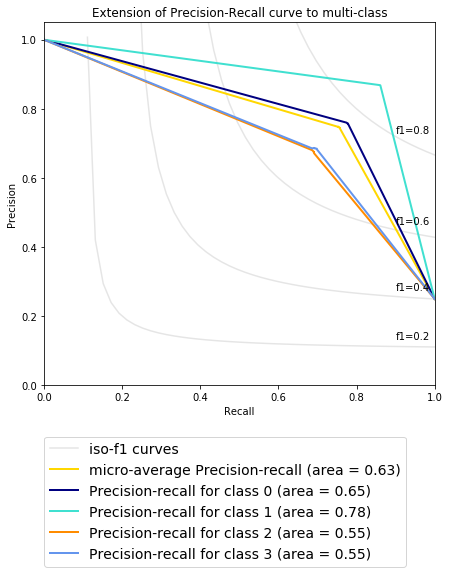

In [24]:
# Precision, Recall, Avg. Precision for Decision Trees
scores = scores.append(prf1_calc(dectree_model, 'DT', N_CLASSES, x_test_w2v, y_test))


In [25]:
clf = OneVsRestClassifier(GaussianNB())
scoring = {'precision': make_scorer(precision_score, average='micro'), 
           'recall': make_scorer(recall_score, average='micro'), 
           'f1': make_scorer(f1_score, average='micro'),
           'roc_auc': make_scorer(roc_auc_score, average='micro'),
           # 'mcc': make_scorer(matthews_corrcoef) <- cannot support multi-label
          }
metrics = cross_validate(
    clf,
    x_train_w2v,
    y_train,
    cv=5,
    scoring = scoring,
    return_train_score=False,
    n_jobs=-1
)
sorted(metrics.keys())


['fit_time',
 'score_time',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc']

In [27]:
metrics


{'fit_time': array([ 9.4257288 , 12.11315131, 12.24181008,  9.48158455, 11.79636312]),
 'score_time': array([5.18003964, 4.63967133, 4.5987978 , 5.2253058 , 4.89950895]),
 'test_precision': array([0.75722522, 0.77106389, 0.7667393 , 0.77066706, 0.76570792]),
 'test_recall': array([0.85916667, 0.87091667, 0.86504167, 0.87708333, 0.85966667]),
 'test_f1': array([0.80498136, 0.81795414, 0.8129295 , 0.82043887, 0.80997154]),
 'test_roc_auc': array([0.88367361, 0.89236111, 0.88865972, 0.89504167, 0.88599306])}

In [28]:
#metrics
cv_result_entries = []

In [29]:
for metric_key in metrics.keys():
        for fold_index, metric_score in enumerate(metrics[metric_key]):
            cv_result_entries.append(('NB', fold_index, metric_key, metric_score))


In [35]:
gnb = OneVsRestClassifier(GaussianNB())
sv = OneVsRestClassifier(svm.LinearSVC(random_state=1))
lreg = OneVsRestClassifier(LogisticRegression(random_state=1))
dtree = OneVsRestClassifier(tree.DecisionTreeClassifier())

model_list = [gnb, sv, lreg, dtree]
model_namelist = ['Gaussian Naive Bayes', 'SVM/Linear SVC', 'Logistic Regression', 'Decision Tree']


In [36]:
scoring = {'precision': make_scorer(precision_score, average='micro'), 
           'recall': make_scorer(recall_score, average='micro'), 
           'f1': make_scorer(f1_score, average='micro'),
           'roc_auc': make_scorer(roc_auc_score, average='micro'),
           # 'mcc': make_scorer(matthews_corrcoef) <- cannot support multi-label
          }

cv_result_entries = []
i = 0


In [37]:
for mod in model_list:
    metrics = cross_validate(
        mod,
        x_train_w2v,
        y_train,
        cv=5,
        scoring = scoring,
        return_train_score=False,
        n_jobs=-1
    )
    for key in metrics.keys():
        for fold_index, score in enumerate(metrics[key]):
            cv_result_entries.append((model_namelist[i], fold_index, key, score))
    i += 1



In [38]:
cv_result_entries = pandas.DataFrame(cv_result_entries)


In [39]:
cv_result_entries.to_csv('cv-results.csv',sep = ',')


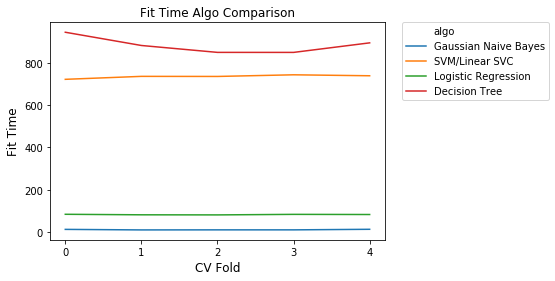

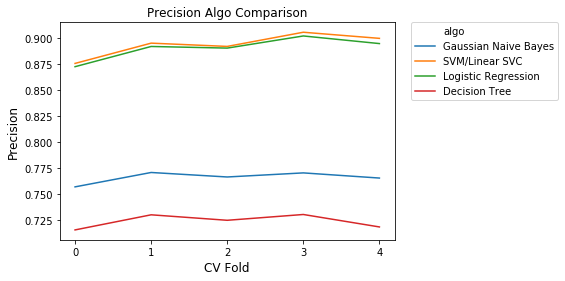

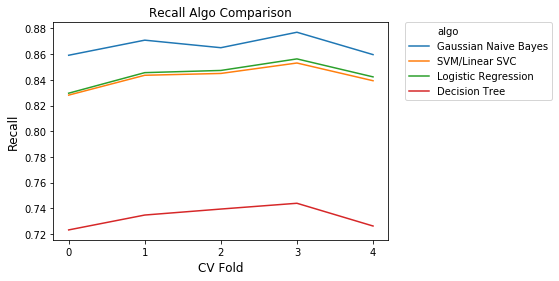

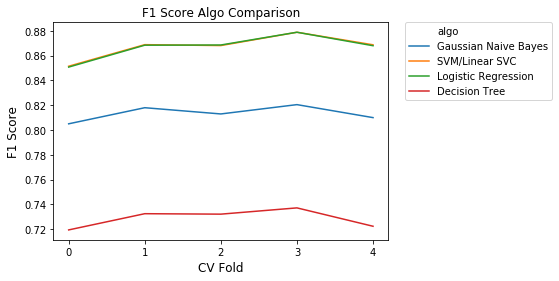

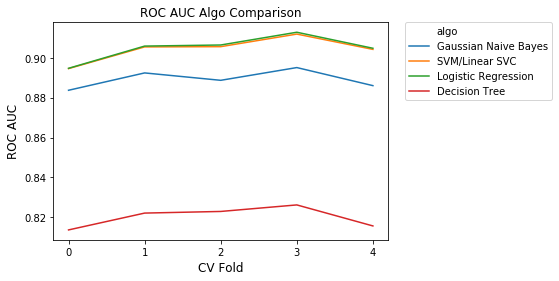

In [75]:
for metric_name, metric in zip(['fit_time',
                                'test_precision',
                                'test_recall',
                                'test_f1',
                                'test_roc_auc'],
                                ['Fit Time',
                                'Precision',
                                'Recall',
                                'F1 Score',
                                'ROC AUC']):
    sns.lineplot(x='cv fold', y='value', hue='algo',
        data=cv_results_df[cv_results_df.metric.eq(f'{metric_name}')])
    plt.title(f'{metric} Algo Comparison', fontsize=12)
    plt.xlabel('CV Fold', fontsize=12)
    plt.ylabel(f'{metric}', fontsize=12)
    plt.xticks([0, 1, 2, 3, 4])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


 ## Import dependencies

In [87]:
# STACKING
x_train_w2v_sample = x_train_w2v.sample(
    n = 4000, replace = False, random_state = 123
)
y_train_sample = train_data_df.category.sample(
    n = 4000, replace = False, random_state = 123
)
y_train_sample = label_binarize(y_train_sample, classes=[1,2,3,4])

estimators = [
              ('nb', GaussianNB()),
              ('svm', svm.LinearSVC())
             ]

sclf = OneVsRestClassifier(StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())
)

metrics = cross_validate(
    sclf,
    x_train_w2v_sample,
    y_train_sample,
    cv=5,
    scoring = scoring,
    return_train_score=False,
    n_jobs=-1
)


In [91]:
res = []
for key in metrics.keys():
    for fold_index, score in enumerate(metrics[key]):
        res.append(('Stacking', fold_index, key, score))



In [94]:
res_df = pandas.DataFrame.from_dict(res)


In [96]:
res_df.columns = ['algo', 'cv fold', 'metric', 'value']


In [97]:
cv_results_inc_ens = pandas.concat([cv_results_df, res_df])


 BOOSTING

In [98]:
from sklearn.ensemble import BaggingClassifier

sclf = OneVsRestClassifier(BaggingClassifier(
    base_estimator=LogisticRegression())
)

metrics = cross_validate(
    sclf,
    x_train_w2v_sample,
    y_train_sample,
    cv=5,
    scoring = scoring,
    return_train_score=False,
    n_jobs=-1
)


In [99]:
res = []
for key in metrics.keys():
    for fold_index, score in enumerate(metrics[key]):
        res.append(('Bagging', fold_index, key, score))


In [100]:
res_df = pandas.DataFrame.from_dict(res)
res_df.columns = ['algo', 'cv fold', 'metric', 'value']
cv_results_inc_ens = pandas.concat([cv_results_inc_ens, res_df])
